In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
!pip install retina-face 
!pip install keras-facenet
!pip install git+https://github.com/rcmalli/keras-vggface.git #vggface 2
!pip install keras_applications --no-deps

import io # Input/Output Module
import os # OS interfaces
import cv2 # OpenCV package
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from urllib import request # module for opening HTTP requests
from matplotlib import pyplot as plt # Plotting library
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

from retinaface import RetinaFace # For rentinaface detector
from sklearn.manifold import TSNE # For TSNE
from sklearn.decomposition import PCA # For PCA feature extractor

#Evaluation Metrics
from sklearn.metrics import accuracy_score # Accuracy
from sklearn.model_selection import cross_val_score # Cross validation

#Classifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

#Improvement 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator #Data Augmentation

from keras_facenet import FaceNet # Facenet pre-trained model

filename = "/opt/conda/lib/python3.7/site-packages/keras_vggface/models.py"
text = open(filename).read()
open(filename, "w+").write(text.replace('keras.engine.topology', 'tensorflow.keras.utils'))

from keras_vggface.vggface import VGGFace
import tensorflow as tf # tensorflow package

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 21.12.2 requires cupy-cuda115, which is not installed.
tfx-bsl 1.12.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.82.0 which is incompatible.
tfx-bsl 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
tensorflow-transform 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
onnx 1.13.1 requires protobuf<4,>=3.20.2, but you have protobuf 3.19.6 which is incompatible.
apache-beam 2.44.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.
  Preparing 

<div style="width:100%; height:140px">
    <img src="https://www.kuleuven.be/internationaal/thinktank/fotos-en-logos/ku-leuven-logo.png/image_preview" width = 300px, heigh = auto align=left>
</div>


KUL H02A5a Computer Vision: Group Assignment 1
---------------------------------------------------------------
Student numbers: <span style="color:red">r0910935, r0771416, r0697140, r0822618, r0867950</span>.

The goal of this assignment is to explore more advanced techniques for constructing features that better describe objects of interest and to perform face recognition using these features. This assignment will be delivered in groups of 5 (either composed by you or randomly assigned by your TA's).

In this assignment you are a group of computer vision experts that have been invited to ECCV 2021 to do a tutorial about  "Feature representations, then and now". To prepare the tutorial you are asked to participate in a kaggle competition and to release a notebook that can be easily studied by the tutorial participants. Your target audience is: (master) students who want to get a first hands-on introduction to the techniques that you apply.

---------------------------------------------------------------
This notebook is structured as follows:
0. Data loading & Preprocessing
1. Feature Representations
2. Evaluation Metrics 
3. Classifiers
4. Experiments
5. Publishing best results
6. Discussion

Make sure that your notebook is **self-contained** and **fully documented**. Walk us through all steps of your code. Treat your notebook as a tutorial for students who need to get a first hands-on introduction to the techniques that you apply. Provide strong arguments for the design choices that you made and what insights you got from your experiments. Make use of the *Group assignment* forum/discussion board on Toledo if you have any questions.

Fill in your student numbers above and get to it! Good luck! 


<div class="alert alert-block alert-info">
<b>NOTE:</b> This notebook is just a example/template, feel free to adjust in any way you please! Just keep things organised and document accordingly!
</div>

<div class="alert alert-block alert-info">
<b>NOTE:</b> Clearly indicate the improvements that you make!!! You can for instance use titles like: <i>3.1. Improvement: Non-linear SVM with RBF Kernel.<i>
</div>
    
---------------------------------------------------------------
# 0. Data loading & Preprocessing

## 0.1. Loading data
The training set is many times smaller than the test set and this might strike you as odd, however, this is close to a real world scenario where your system might be put through daily use! In this session we will try to do the best we can with the data that we've got! 

In [2]:
# Input data files are available in the read-only "../input/" directory

train = pd.read_csv('/kaggle/input/kul-h02a5a-computer-vision-ga1-2023/train_set.csv', index_col = 0)
train.index = train.index.rename('id')

test = pd.read_csv(
    '/kaggle/input/kul-h02a5a-computer-vision-ga1-2023/test_set.csv', index_col = 0)
test.index = test.index.rename('id')

# read the images as numpy arrays and store in "img" column
train['img'] = [cv2.cvtColor(np.load('/kaggle/input/kul-h02a5a-computer-vision-ga1-2023/train/train_{}.npy'.format(index), allow_pickle=False), cv2.COLOR_BGR2RGB) 
                for index, row in train.iterrows()]

test['img'] = [cv2.cvtColor(np.load('/kaggle/input/kul-h02a5a-computer-vision-ga1-2023/test/test_{}.npy'.format(index), allow_pickle=False), cv2.COLOR_BGR2RGB) 
                for index, row in test.iterrows()]
  

train_size, test_size = len(train),len(test)

"The training set contains {} examples, the test set contains {} examples.".format(train_size, test_size)

'The training set contains 80 examples, the test set contains 1816 examples.'

*Note: this dataset is a subset of the* [*VGG face dataset*](https://www.robots.ox.ac.uk/~vgg/data/vgg_face/).

## 0.2. A first look
Let's have a look at the data columns and class distribution.

In [3]:
# The training set contains an identifier, name, image information and class label
train.head(1)

name  class                                                img
id                                                                      
0   Mila_Kunis      2  [[[50, 31, 25], [49, 30, 24], [49, 30, 24], [4...

In [4]:
# The test set only contains an identifier and corresponding image information.

test.head(1)

img
id                                                   
0   [[[209, 210, 205], [208, 209, 204], [208, 209,...

In [5]:
# The class distribution in the training set:
train.groupby('name').agg({'img':'count', 'class': 'max'})

img  class
name                       
Jesse_Eisenberg   30      1
Michael_Cera      10      0
Mila_Kunis        30      2
Sarah_Hyland      10      0

Note that **Jesse is assigned the classification label 1**, and **Mila is assigned the classification label 2**. The dataset also contains 20 images of **look alikes (assigned classification label 0)** and the raw images. 

## 0.3. Preprocess data
### 0.3.1 Example: HAAR face detector
In this example we use the [HAAR feature based cascade classifiers](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html) to detect faces, then the faces are resized so that they all have the same shape. If there are multiple faces in an image, we only take the first one. 

<div class="alert alert-block alert-info"> <b>NOTE:</b> You can write temporary files to <code>/kaggle/temp/</code> or <code>../../tmp</code>, but they won't be saved outside of the current session
</div>


The HAARPreprocessor() class is a pre-processing pipeline for facial recognition tasks, built around HAAR feature-based cascade classifiers. Its constructor takes two arguments - the path to the cascade classifier file and the output face size.

In [6]:
class HAARPreprocessor():
    """Preprocessing pipeline built around HAAR feature based cascade classifiers. """
    
    def __init__(self, path, face_size):
        self.face_size = face_size
        file_path = os.path.join(path, "haarcascade_frontalface_default.xml")
        if not os.path.exists(file_path): 
            if not os.path.exists(path):
                os.mkdir(path)
            self.download_model(file_path)
        
        self.classifier = cv2.CascadeClassifier(file_path)
  
    def download_model(self, path):
        url = "https://raw.githubusercontent.com/opencv/opencv/master/data/"\
            "haarcascades/haarcascade_frontalface_default.xml"
        
        with request.urlopen(url) as r, open(path, 'wb') as f:
            f.write(r.read())
            
    def detect_faces(self, img):
        """Detect all faces in an image."""
        
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return self.classifier.detectMultiScale(
            img_gray,
            scaleFactor=1.2,
            minNeighbors=5,
            minSize=(20, 20),
            flags=cv2.CASCADE_SCALE_IMAGE
        )
        
    def extract_faces(self, img):
        """Returns all faces (cropped) in an image."""
        
        faces = self.detect_faces(img)

        return [img[y:y+h, x:x+w] for (x, y, w, h) in faces]
    
    def preprocess(self, data_row):
        faces = self.extract_faces(data_row['img'])
        
        # if no faces were found, return None
        if len(faces) == 0:
            nan_img = np.empty(self.face_size + (3,))
            nan_img[:] = np.nan
            return nan_img
        
        # only return the first face
        return cv2.resize(faces[0], self.face_size, interpolation = cv2.INTER_AREA)
            
    def __call__(self, data):
        return np.stack([self.preprocess(row) for _, row in data.iterrows()]).astype(int)

The detect_faces() function detects all faces in an image and returns their coordinates and sizes as a list. The extract_faces() function extracts all faces from an image and returns them as a list. The preprocess() function extracts and resizes the face to the desired size. Finally, the call() function accepts a dataset as input, applies the face extraction and resizing operations to each image in the dataset, and returns a numpy array containing all the face images.

### 0.3.2 RetinaFace face detectors
[*RetinaFace*](https://github.com/serengil/retinaface) is a deep learning-based face detection library that provides facial landmarks. It was developed by InsightFace and is a single-stage face detector that has been accepted by CVPR 20202. It has been used to detect faces in images and videos with high accuracy.

Here we use the **extract_faces()** method to get the extracted faces in one figure and we add the "**align = True**" to align faces. Experiments show that alignment increases the face recognition accuracy almost 1%.


Reference: [*Serengil, Sefik Ilkin, and Alper Ozpinar. "Lightface: A hybrid deep face recognition framework." 2020 Innovations in Intelligent Systems and Applications Conference (ASYU). IEEE, 2020*](https://doi.org/10.1109/ASYU50717.2020.9259802)

[*Serengil, Sefik Ilkin, and Alper Ozpinar. "Hyperextended lightface: A facial attribute analysis framework." 2021 International Conference on Engineering and Emerging Technologies (ICEET). IEEE, 2021*](https://doi.org/10.1109/ICEET53442.2021.9659697)


In [7]:
class RetinaFacePreprocessor():
    """Preprocessing pipeline built around HAAR feature based cascade classifiers. """
    
    def __init__(self,face_size):
        self.face_size = face_size
        self.detector = RetinaFace
    def getleftmost(self,img):
        faces = self.detector.detect_faces(img, threshold=0.99)
        
        if type(faces) == dict:          
            min_facial_area_x = float('inf')
            min_face_key = None

            for face_key, face_info in faces.items():
                facial_area_x = face_info['facial_area'][0]
                if facial_area_x < min_facial_area_x:
                    min_facial_area_x = facial_area_x
                    min_face_key = face_key
            
            return int(min_face_key.split("_")[1]) - 1
        else:
            return 0
    
    def preprocess(self, data_row):
        faces = self.detector.extract_faces(data_row['img'],threshold=0.99, align = True)
        num = self.getleftmost(data_row['img'])
        # if no faces were found, return None
        if len(faces) == 0:
            nan_img = np.empty(self.face_size + (3,))
            nan_img[:] = np.nan
            return nan_img
        # only return the most left face
        return cv2.resize(faces[0], self.face_size, interpolation = cv2.INTER_AREA)
            
    def __call__(self, data):
        return np.stack([self.preprocess(row) for _, row in data.iterrows()]).astype(int)

In [8]:
def plot_image_sequence(data, n, imgs_per_row=7):
    n_rows = 1 + int(n/(imgs_per_row+1))
    n_cols = min(imgs_per_row, n)

    f,ax = plt.subplots(n_rows,n_cols, figsize=(10*n_cols,10*n_rows))
    for i in range(n):
        if n == 1:
            ax.imshow(data[i])
        elif n_rows > 1:
            ax[int(i/imgs_per_row),int(i%imgs_per_row)].imshow(data[i])
        else:
            ax[int(i%n)].imshow(data[i])
    plt.show()

In [9]:
# parameter to play with 
FACE_SIZE = (100, 100)
    
# Preprocessed data to get faces
# Choose the processing method
choose_preprocessor = 1 # HAAR = 0; RetinaFace = 1
preprocessor = [HAARPreprocessor(path = '../../tmp', face_size=FACE_SIZE),RetinaFacePreprocessor(face_size=FACE_SIZE)][choose_preprocessor]

train_X, train_y = preprocessor(train), train['class'].values
test_X = preprocessor(test)

Directory  /root /.deepface created
Directory  /root /.deepface/weights created
retinaface.h5 will be downloaded from the url https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5
To: /root/.deepface/weights/retinaface.h5
100%|██████████| 119M/119M [00:00<00:00, 162MB/s]


### Load the data if already exists

In [10]:
# load preprocessed data
is_use_prepared_data = True
if is_use_prepared_data:
    train_X = np.load('../input/cvpreprocessdata/train_X.npy')
    train_y = np.load('../input/cvpreprocessdata/train_y.npy')
    test_X = np.load('../input/cvpreprocessdata/test_X.npy',allow_pickle=True)
    test_X_multifaces = np.load('../input/cvpreprocessdata/test_X_multifaces.npy',allow_pickle=True)
for i in range(test_X_multifaces.shape[0]):
    test_X_multifaces[i] = test_X_multifaces[i].astype(np.uint8)

### 0.3.4 Visualization

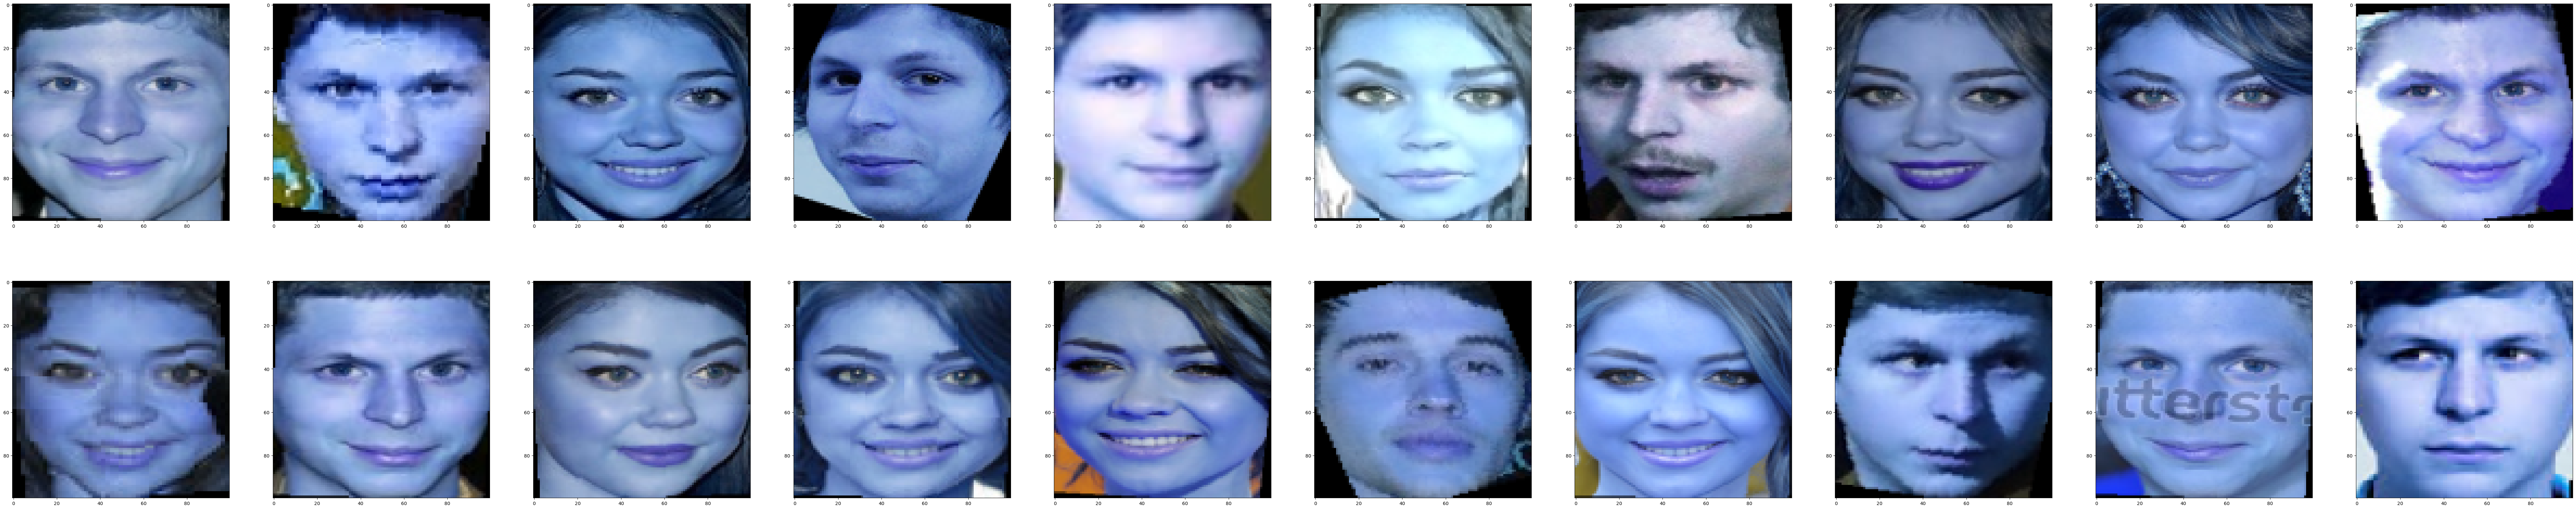

In [11]:
# plot faces of Michael and Sarah

plot_image_sequence(train_X[train_y == 0], n=20, imgs_per_row=10)

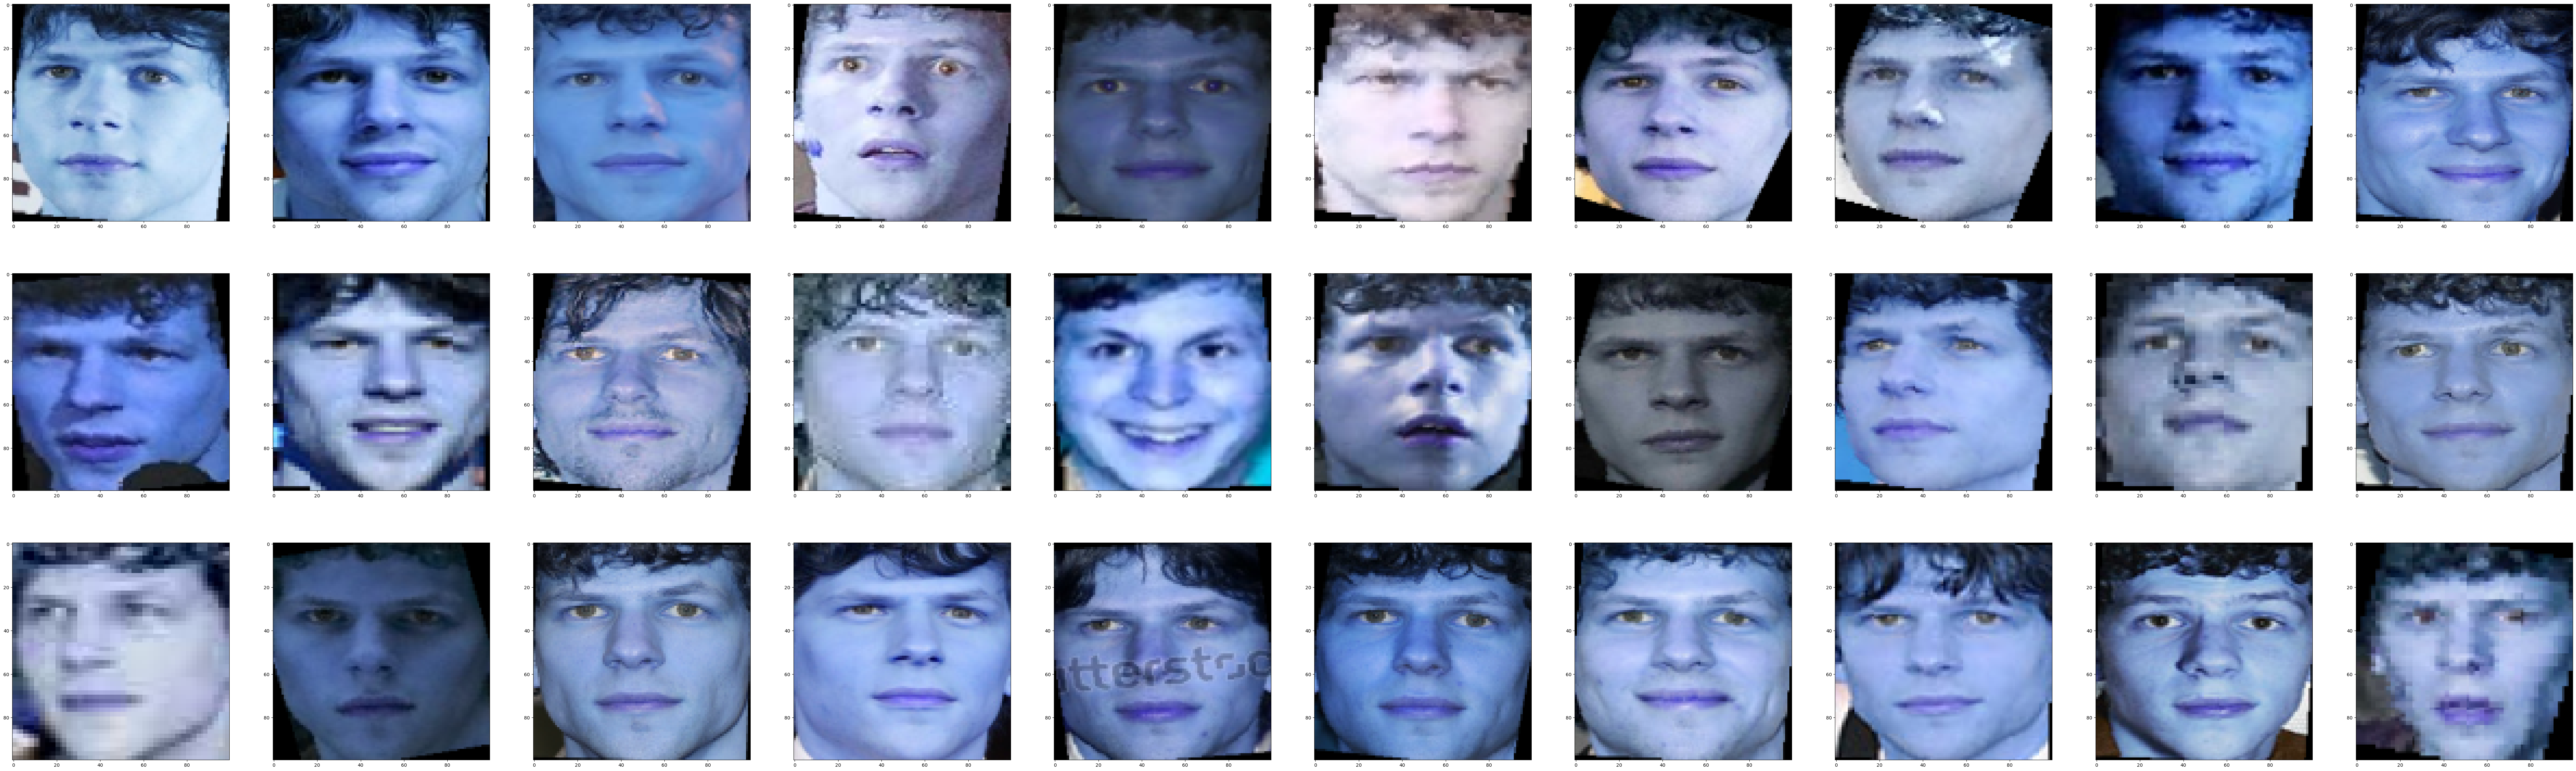

In [12]:
# plot faces of Jesse

plot_image_sequence(train_X[train_y == 1], n=30, imgs_per_row=10)

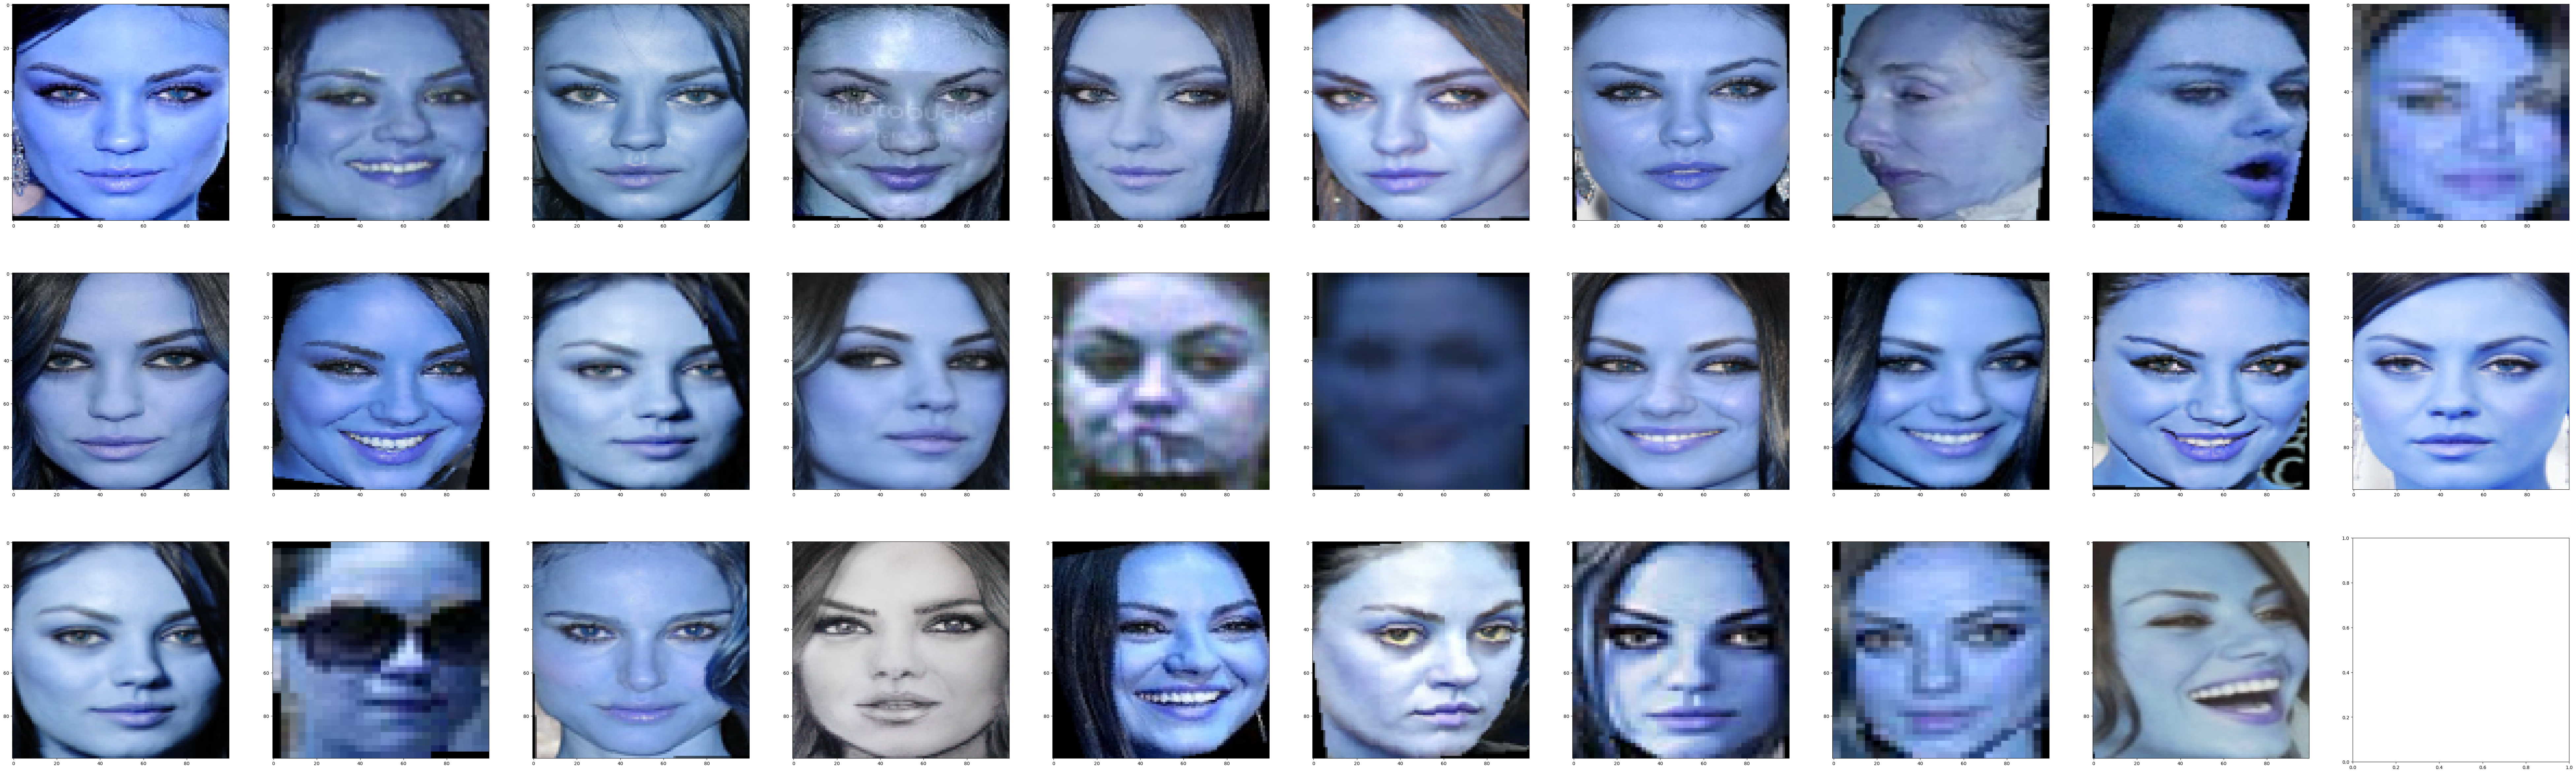

In [13]:
# plot faces of Mila

plot_image_sequence(train_X[train_y == 2], n=29, imgs_per_row=10)

## 0.4. Store Preprocessed data (optional)
<div class="alert alert-block alert-info">
<b>NOTE:</b> You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All". Feel free to use this to store intermediary results.
</div>

In [14]:
#save preprocessed data
prep_path = '/kaggle/working/prepped_data/'
if not os.path.exists(prep_path):
   os.mkdir(prep_path)
    
np.save(os.path.join(prep_path, 'train_X.npy'), train_X)
np.save(os.path.join(prep_path, 'train_y.npy'), train_y)
np.save(os.path.join(prep_path, 'test_X.npy'), test_X)


Now we are ready to rock!

# 1. Feature Representations
## 1.0. Example: Identify feature extractor
Our example feature extractor doesn't actually do anything... It just returns the input:
$$
\forall x : f(x) = x.
$$

It does make for a good placeholder and baseclass ;).

In [15]:
class IdentityFeatureExtractor:
    """A simple function that returns the input"""
    
    def transform(self, X):
        return X
    
    def __call__(self, X):
        return self.transform(X)

## 1.1. Baseline 1: HOG feature extractor/Scale Invariant Feature Transform
In the HOG algorithm, the image is first divided into several small local blocks. Then, for each local block, calculate its gradient histogram in different directions, and concatenate these histograms to form the feature vector of this local block. Finally, all feature vectors are stitched together to form a feature description of the image.

The following is the mathematical formula for calculating the direction of the gradient:

$$\theta(x,y) = \begin{cases} \text{atan2}(G_y(x,y), G_x(x,y)) & \text{if } G_x(x,y) \geq 0 \\ \text{atan2}(G_y(x,y), G_x(x,y)) + \pi & \text{if } G_x(x,y) < 0 \end{cases}$$


Where $G_x$ and $G_y$ are the gradients of the image in the x and y directions, respectively, and $\theta$ is the gradient direction. The values of the gradient orientation will be classified into different orientation bins, and the gradient orientation histogram of each bin is calculated, which is used to generate the HOG feature vector.

In [16]:
class HOGFeatureExtractor(IdentityFeatureExtractor):
    """A HOG feature extractor that returns the HOG feature"""
    def __init__(self,win_size=(100,100), block_size=(20,20), block_stride=(20,20), cell_size=(10,10)):
        self.hog = cv2.HOGDescriptor(_winSize = win_size, _blockSize = block_size, _blockStride = block_size, _cellSize = cell_size, _nbins=9)
    
    def fit(self, X, y=None):
        return self        
    def transform(self, X):
        X = X.astype(np.uint8)
        y = list(map(lambda x: self.hog.compute(x), X))
        y = np.stack(y, axis=0)
        return y
        
    def __call__(self, X):
        return self.transform(X)

We have a class called HOGFeatureExtractor that inherits from IdentityFeatureExtractor. It uses a Histogram of Oriented Gradients (HOG) descriptor to extract features from an input image. The parameters of the HOG descriptor, such as the window size, block size, block stride, cell size, and number of orientation bins, can be set during initialization. The transform method is used to extract HOG features from the input image, and the call method calls the transform method to extract features from a batch of images.

### 1.1.1. t-SNE Plots
t-SNE is a method for data dimensionality reduction and visualization. The basic idea is to map high-dimensional data into two-dimensional or three-dimensional space so that we can observe and understand the structure of the data in a graphical interface.

$$
\begin{aligned}
C=\sum_{i} KL(P_i||Q_i)=\sum_{i}\sum_{j}p_{ij}\log{\frac{p_{ij}}{q_{ij}}} \\
p_{ij}=\frac{\exp{(-\lVert x_i - x_j \rVert^2 / 2\sigma_i^2)}}{\sum_k\sum_l\exp{(-\lVert x_k - x_l \rVert^2 / 2\sigma_k^2)}} \\
q_{ij}=\frac{(1+\lVert y_i - y_j \rVert^2)^{-1}}{\sum_k\sum_l(1+\lVert y_k - y_l \rVert^2)^{-1}}
\end{aligned}
$$

Among them, $p_{ij}$ and $q_{ij}$ are the probability distributions corresponding to the input data and the dimensionally reduced data respectively, $x_i$ and $y_i$ are the representations of the original data and the dimensionally reduced data respectively, $\ sigma_i$ is the variance parameter that controls the sample distribution. The value of the objective function $C$ is the Kullback-Leibler divergence of the input data and the data distribution after dimensionality reduction.

The goal of t-SNE is to minimize differences in low-dimensional representations while preserving similarity information in high-dimensional data. It achieves this by defining two probability distributions in a high-dimensional space and a low-dimensional space, and then uses KL divergence to measure the difference between them.

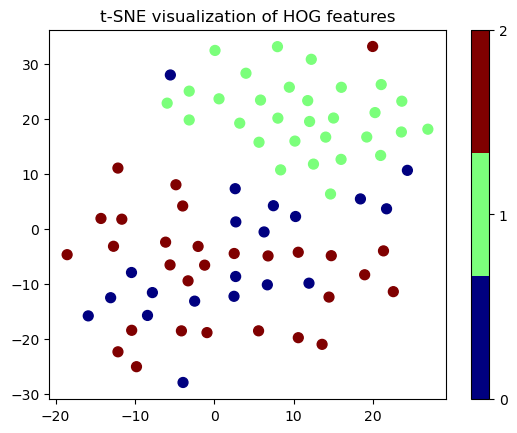

In [17]:

# Assuming train_X and train_y are already loaded
X = train_X
y = train_y

# Extract HOG features
feature_extractor = HOGFeatureExtractor()
hog_features = feature_extractor.transform(X)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
reduced_features = tsne.fit_transform(hog_features)

# Visualize the results
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=y, cmap=plt.cm.get_cmap('jet', len(np.unique(y))), marker='o', s=50)
plt.colorbar(ticks=range(len(np.unique(y))))
plt.title('t-SNE visualization of HOG features')
plt.show()

We reduce the dimensionality of the extracted HOG features by calling the t-SNE function in the sklearn library, and visualize the results after dimensionality reduction. First use the HOGFeatureExtractor class to extract HOG features from the training data. Each point on the image represents a face, and different colors represent different categories, that is, the identity of the person to which the face belongs.

### 1.1.2. Discussion

In this example, we explore methods for classifying and visualizing image data using HOG features and the t-SNE dimensionality reduction algorithm. HOG features are widely used in the field of computer vision and can be used to describe the shape and texture features of images. The t-SNE algorithm can reduce the dimensionality of high-dimensional data into two or three dimensions, allowing us to visualize data and better understand their structure.

In our experiments, we use the HOG feature extractor to extract the HOG features of images and use the t-SNE algorithm to reduce their dimensionality into a two-dimensional space. We evaluated the visualization results and found that the t-SNE algorithm can cluster different image categories together, indicating that this method is effective in image classification and visualization.


## 1.2. Baseline 2: PCA feature extractor


PCA is a powerful dimensionality reduction technique that has wide applications in image recognition and feature extraction. The main idea of PCA is to project high-dimensional data onto a lower-dimensional subspace while preserving most of the variability in the data. This is achieved by calculating the eigenvectors and eigenvalues of the covariance matrix of the data and selecting the top k eigenvectors as the basis for the lower-dimensional subspace. The eigenvectors, also known as eigenfaces in image recognition, capture the most important patterns in the data, while the eigenvalues quantify the amount of variability captured by each eigenvector. The mathematical formula for PCA is given by the eigendecomposition of the covariance matrix:

$$\Sigma = \frac{1}{n} \sum_{i=1}^{n}(x_i-\mu)(x_i-\mu)^T$$

where $\Sigma$ is the covariance matrix, $n$ is the number of samples, $x_i$ is the $i$th sample, and $\mu$ is the mean vector of all samples. The eigenvectors of $\Sigma$ are the principal components, and the eigenvalues represent the amount of variance explained by each principal component.

In [18]:
class PCAFeatureExtractor(IdentityFeatureExtractor):
    """A PCA feature extractor that reduces the dimensionality of input data."""
    
    def __init__(self, n_components=20):
        self.n_components = n_components
        self.pca = PCA(n_components=self.n_components)
        self.X_mean = 0
        self.X_std = 1
        
    def fit(self, X):
        X_temp = self.preprocess(X)
        self.X_mean = np.mean(X_temp)
        self.X_std = np.std(X_temp)
        X_temp = (X_temp - self.X_mean) / self.X_std
        self.pca.fit(X_temp)

    def transform(self, X):
        X_temp = self.preprocess(X)
        X_temp = (X_temp - self.X_mean) / self.X_std
        return self.pca.transform(X_temp)
    
    def preprocess(self, X):
        X_temp = []
        for img in X:
            img = img.astype(np.uint8)
            img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            img_gray_flat = img_gray.reshape(-1)  # Flatten the grayscale image
            X_temp.append(img_gray_flat)
        return np.array(X_temp)
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)
    
    def inverse_transform(self, X):
        return self.pca.inverse_transform(X)

    def __call__(self, X):
        return self.transform(X)


### 1.2.1 How to determine the number of principal components

In [19]:
# Explained variance ratio vs. number of principal components visualization on training set
feature_extractor = PCAFeatureExtractor(n_components=70)
feature_extractor.fit(train_X)

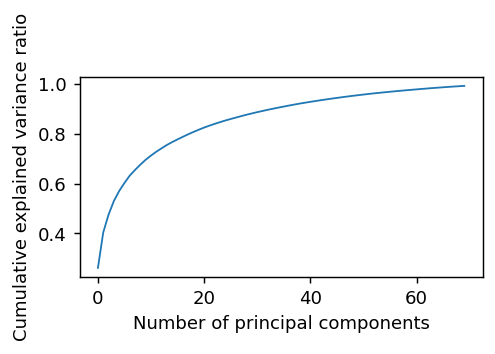

In [20]:
plt.figure(1, figsize=(4,2), dpi=130)
plt.plot(np.cumsum(feature_extractor.pca.explained_variance_ratio_), linewidth=1)
plt.xlabel('Number of principal components')
plt.ylabel('Cumulative explained variance ratio')
plt.show()

The plot shows the percentage of total variance in the data explained by the principal components. At the point n_components=30, the cumulative explained variance ratio begins to level off. 

In [21]:
# Reconstruction loss (MSE) vs. number of principal components visualization on training set
err = []

for i in list(range(1, 70, 1)):
    pca_extractor = PCAFeatureExtractor(n_components=i)
    
    X_pca = pca_extractor.fit_transform(train_X)
    # Reconstruction
    X_recon = pca_extractor.inverse_transform(X_pca)
    
    X = pca_extractor.preprocess(train_X)
    X = (X - np.mean(X)) / np.std(X)
    
    err.append(np.sum(np.power(X_recon - X,2))/len(X))
    

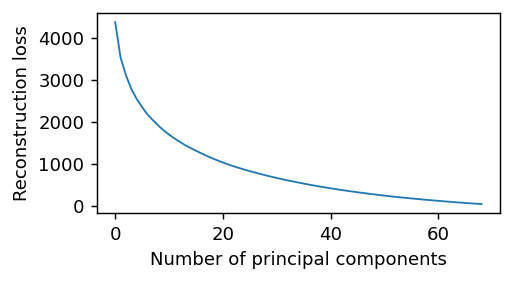

In [22]:
plt.figure(1, figsize=(4,2), dpi=130)
plt.plot(err, linewidth=1)
plt.xlabel('Number of principal components')
plt.ylabel('Reconstruction loss')
plt.show()

At the point n_components=30, the reconstruction loss begins to level off. 

### 1.2.2. Eigenface Plots
Each eigenface is a vector in the high-dimensional space of face images that captures a specific feature or pattern of variation in the dataset. Eigenfaces can be used for face recognition and face reconstruction. To use eigenfaces for face recognition, a new face image is projected onto the eigenspace, which is the space spanned by the eigenvectors. This is done by computing the dot product of the image vector with each eigenface. The resulting coefficients represent the contribution of each eigenface to the image. To reconstruct a face image from its coefficients, the coefficients are multiplied by the corresponding eigenfaces and then summed. The resulting vector is the reconstructed image. The quality of the reconstruction depends on the number of eigenfaces used and the corresponding coefficients.

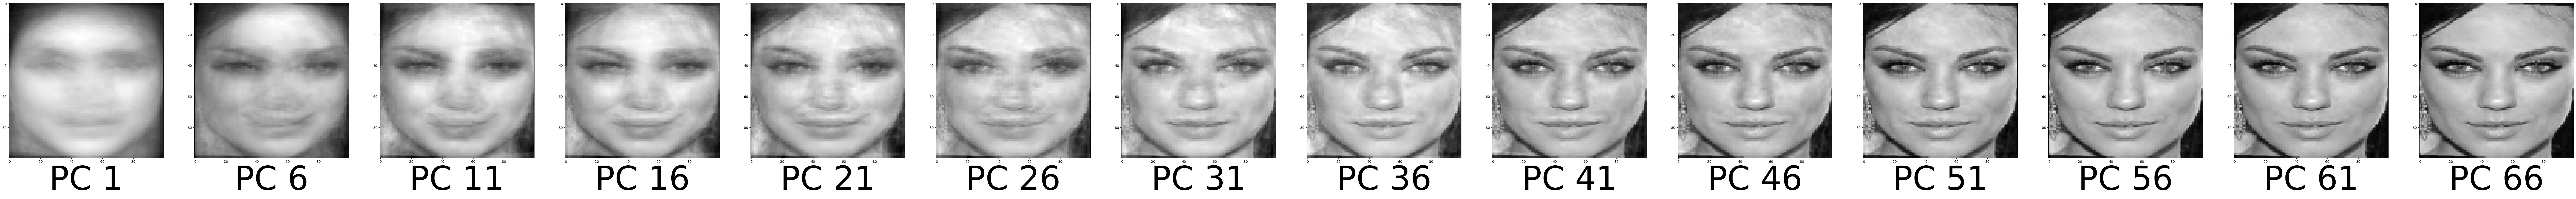

In [23]:
fig, ax = plt.subplots(1,14, figsize=(10*14,10))

idx = 0
for i in list(range(1, 70, 5)):
    pca_extractor = PCAFeatureExtractor(n_components=i)
    X_pca = pca_extractor.fit_transform(train_X)
    # Reconstruction
    X_recon = pca_extractor.inverse_transform(X_pca)
    
    ax[idx].imshow(X_recon[0].reshape((train_X.shape[1], train_X.shape[2])), cmap='gray')
    ax[idx].set_xlabel("PC "+str(i), fontsize=100)
    idx += 1
plt.show()

As we increase the number of eigenfaces used for reconstruction, the reconstructed images become more similar to the original images in terms of the overall appearance and features. This is because the additional eigenfaces capture more information and details about the original images, allowing for a better reconstruction. However, when the number of eigenfaces reaches some point, additional eigenfaces contribute very little to the reconstruction and the improvement in similarity becomes negligible.

### 1.2.3. Feature Space Plots
Feature space plots are helpful in understanding the distribution of data points in a high-dimensional space after dimensionality reduction using techniques such as PCA. They can provide insights into the underlying structure of the data and help identify patterns or clusters that may not be apparent in the original high-dimensional space.

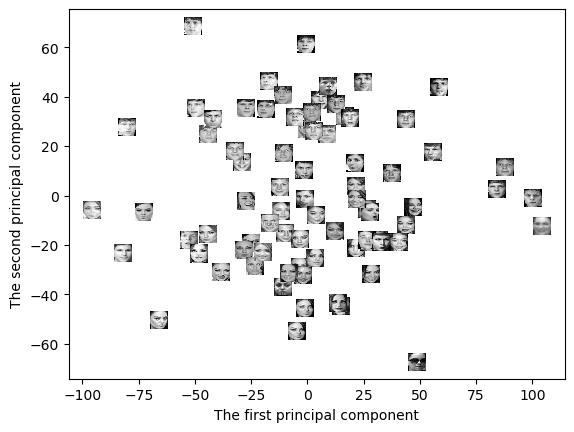

In [24]:
# Perform PCA on the dataset
pca_extractor = PCAFeatureExtractor(n_components=2)
X_pca = pca_extractor.fit_transform(train_X)

# Plot the first two principal components against each other
fig, ax = plt.subplots()
ax.scatter(X_pca[:, 0], X_pca[:, 1])

# Replace each point with the corresponding original image
img_size = 0.5
for i in range(train_X.shape[0]):
    img = train_X[i].astype(np.uint8)
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    x, y = X_pca[i, :]
    img_box = OffsetImage(img_gray, zoom=img_size/4, cmap='gray')
    ab = AnnotationBbox(img_box, (x, y), xycoords='data', frameon=False)
    ax.add_artist(ab)

plt.xlabel('The first principal component')
plt.ylabel('The second principal component')
plt.show()

From this two-dimensional plot, we can roughly see that some photos belonging to the same person are clustered together.

### 1.2.4. Discussion
Questions:

1. How to convert my image (you can work in color if you like) dataset to a 2D matrix?

The code in the provided PCAFeatureExtractor class converts the images to grayscale and then flattens them into a 1D vector. These vectors are then stacked horizontally to form a 2D matrix, where each row represents an image.

2. Can you exploit the dimensionality of this data matrix to make your computations more effective?

Yes, the dimensionality of the data matrix can be exploited to make computations more effective using dimensionality reduction techniques such as PCA.

3. Mean subtraction or not?

Yes, mean subtraction is performed in the fit and transform methods of the PCAFeatureExtractor class. Mean subtraction is usually performed before applying PCA to the data. This involves subtracting the mean of each feature (column) from the data, so that the mean of each feature becomes zero. This is done to ensure that the first principal component captures the direction of maximum variance in the data. 

4. Shall we use eigenvalue or singular value decomposition?

We can use either eigenvalue decomposition (EVD) or singular value decomposition (SVD) to perform PCA on the data. However, SVD is more numerically stable and efficient, especially for large datasets.

5. How many non-zero eigenvalues/singular values should we have?

The number of non-zero eigenvalues/singular values should be chosen based on the amount of variance we want to retain in the data. This can be determined by looking at the explained variance ratio plot, which shows the cumulative sum of explained variances for each principal component. 

6. Did you need specific pre-processing steps before computing these feature descriptors on your images (which ones and why)?

Yes, the images needed to be converted to grayscale and flattened into a 1D vector. Additionally, mean subtraction was performed to center the data around zero before performing PCA.

7. How many non-zero eigenvalues did you have, why is this? Did the visualisation show good discriminative and robustness properties?

The number of non-zero eigenvalues we have depends on the number of principal components we choose to retain. The number of components chosen is 30, so we would have 30 non-zero eigenvalues. The visualization shows good discriminative and robustness properties if the classes are well-separated and there are no overlapping regions in the feature space.

# 2. Evaluation Metrics
## 2.1  Accuracy
As example metric we take the accuracy. Informally, accuracy is the proportion of correct predictions over the total amount of predictions. It is used a lot in classification but it certainly has its disadvantages.

Accuracy is a performance metric that measures the proportion of correct predictions made by a classification model compared to the total number of predictions. It is calculated as:

Accuracy = (Number of Correct Predictions) / (Total Number of Predictions)

Accuracy is a simple and intuitive metric.

## 2.2  Cross Validation

Cross-validation is a technique used to evaluate the performance of a machine learning model and to estimate its generalization to unseen data. It helps to mitigate overfitting and provides a more reliable estimate of model performance. The most common form of cross-validation is k-fold cross-validation. 

1. The dataset is divided into k equally sized subsets (or "folds").

2. The model is trained k times, each time using k-1 folds for training and the remaining fold for validation.

3. The model's performance is evaluated on each validation fold, and the results are averaged to obtain a final performance estimate.

# 3. Classifiers
## 3.0. Example: The *'not so smart'* classifier
This random classifier is not very complicated. It makes predictions at random, based on the distribution obseved in the training set. **It thus assumes** that the class labels of the test set will be distributed similarly to the training set.

In [25]:
class RandomClassificationModel:
    """Random classifier, draws a random sample based on class distribution observed 
    during training."""
    
    def fit(self, X, y):
        """Adjusts the class ratio instance variable to the one observed in y. 

        Parameters
        ----------
        X : tensor
            Training set
        y : array
            Training set labels

        Returns
        -------
        self : RandomClassificationModel
        """
        
        self.classes, self.class_ratio = np.unique(y, return_counts=True)
        self.class_ratio = self.class_ratio / self.class_ratio.sum()
        return self
        
    def predict(self, X):
        """Samples labels for the input data. 

        Parameters
        ----------
        X : tensor
            dataset
            
        Returns
        -------
        y_star : array
            'Predicted' labels
        """

        np.random.seed(0)
        return np.random.choice(self.classes, size = X.shape[0], p=self.class_ratio)
    
    def __call__(self, X):
        return self.predict(X)
    

## 3.1 Baseline: 
### 3.1.1 SVM classfifier

This class, SVMModel, is a custom implementation of a Support Vector Machine (SVM) classifier, inheriting from BaseEstimator and ClassifierMixin from the scikit-learn library. It is designed to be used for multi-class classification tasks, with the ability to handle multiple faces in a single input figure. The class has the following attributes and methods:

**fit()**: Trains the SVM model using the input data X and corresponding labels y. It creates an SVM pipeline with standard scaling and an SVC classifier using the specified parameters.

**predict()**: Predicts the class labels for the input data X using the trained SVM model. It returns the predicted class labels as a NumPy array.

**predict_figures()**: Predicts the class labels for a set of figures, each containing multiple faces. The input X should have the shape (n_figures, n_faces, figure_data). The method returns a NumPy array of predicted class labels for each figure.

**predict_faces()**: Predicts the class label for a single input figure containing multiple faces. It initializes a dictionary called **vote**, which will store the highest probability found so far for each class. For each face in the input figure, it computes the class probabilities using the trained SVM model. It then updates the vote dictionary with the highest probability found for each class. After processing all the faces, the method determines the final class label based on the highest probabilities and given thresholds for classes 1 and 2. It returns the predicted class label as an integer.

**__call__()**: A callable method that acts as a shortcut to predict_figures. It allows the class instance to be called as a function, taking the same arguments as the predict_faces method.

The SVMModel class is a versatile and customizable SVM classifier, designed specifically to handle multi-class classification tasks involving multiple faces in an input figure.

In [26]:

class SVMModel(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1, gamma='auto', kernel='sigmoid', probability=True):      
        self.C = C
        self.gamma=gamma
        self.kernel=kernel
        self.probability=probability
    
    def fit(self, X, y):     
        self.svm_ = make_pipeline(StandardScaler(), SVC(C=self.C, gamma=self.gamma, kernel=self.kernel, probability=self.probability))
        self.svm_.fit(X, y)
        self.is_fitted_ = True
        return self
        
    def predict(self, X):
        results = self.svm_.predict_proba(X)
        return np.argmax(results, axis=1)
    
    def predict_figures(self, X, threshold_1=0.85, threshold_2=0.85):    
        y = []
        for i in range(X.shape[0]):
            y.append(self.predict_faces(X[i], threshold_1, threshold_2))
        return np.stack(y, axis=0)
    
    def predict_faces(self, X, threshold_1=0.85, threshold_2=0.85):
        vote = {0:0, 1:0, 2:0}
        for i in range(X.shape[0]):
            proba = self.svm_.predict_proba([X[i]])
            for clas in range(len(vote)):
                if vote[clas] < proba[0][clas]:
                    vote[clas] = proba[0][clas]
          
        class_num = 0
        if vote[1] < threshold_1 and vote[2] < threshold_2:
            class_num = 0
        elif vote[1] >= vote[2]:
            if vote[0] >= vote[1]:
                class_num = 0
            else:
                class_num = 1
        elif vote[1] < vote[2]:
            if vote[0] >= vote[2]:
                class_num = 0
            else:
                class_num = 2
        return class_num
    
    def __call__(self, X, threshold_1=0.85, threshold_2=0.85):
        return self.predict_figures(X, threshold_1, threshold_2)

### 3.1.2. Random Forest

**Random Forest** is an ensemble learning algorithm used for both classification and regression tasks. It operates by constructing multiple decision trees during the training phase and outputting the class that is the mode of the classes (classification) or the mean prediction (regression) of the individual trees.

Random Forest is a popular algorithm due to its versatility, simplicity, and good performance on a wide range of problems. Here we use the scikit-learn to perform **Random Forest** with the same structure as the previous **SVMModel**

In [27]:

class RandomForestModel(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=100, criterion='gini', max_depth=None, max_features='auto'):
        self.n_estimators = n_estimators
        self.criterion = criterion
        self.max_depth = max_depth
        self.max_features = max_features

    def fit(self, X, y):     
        self.rf_ = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=self.n_estimators, criterion=self.criterion, max_depth=self.max_depth, max_features=self.max_features))
        self.rf_.fit(X, y)
        self.is_fitted_ = True
        return self
        
    def predict(self, X):
        results = self.rf_.predict_proba(X)
        return np.argmax(results, axis=1)
    
    def predict_figures(self, X, threshold_1=0.85, threshold_2=0.85):    
        y = []
        for i in range(X.shape[0]):
            y.append(self.predict_faces(X[i], threshold_1, threshold_2))
        return np.stack(y, axis=0)
    
    def predict_faces(self, X, threshold_1=0.85, threshold_2=0.85):
        vote = {0:0, 1:0, 2:0}
        for i in range(X.shape[0]):
            proba = self.rf_.predict_proba([X[i]])
            for clas in range(len(vote)):
                if vote[clas] < proba[0][clas]:
                    vote[clas] = proba[0][clas]
          
        class_num = 0
        if vote[1] < threshold_1 and vote[2] < threshold_2:
            class_num = 0
        elif vote[1] >= vote[2]:
            if vote[0] >= vote[1]:
                class_num = 0
            else:
                class_num = 1
        elif vote[1] < vote[2]:
            if vote[0] >= vote[2]:
                class_num = 0
            else:
                class_num = 2
        return class_num
    
    def __call__(self, X, threshold_1=0.85, threshold_2=0.85):
        return self.predict_figures(X, threshold_1, threshold_2)


### 3.1.3. Logistic Regression

**Logistic Regression** is a statistical method used for binary and multi-class classification problems. It is based on the concept of using a logistic function to model the probability of a certain class or event. In the context of face recognition, Logistic Regression can be used to classify whether a given face belongs to a particular person or not, or to identify a person from a set of known individuals.

When it comes to face recognition, the performance of Logistic Regression largely depends on the quality and representation of the input features. 

Here we put the structure of **LogisticRegressionModel** as a baseline model for comparison.

In [28]:

class LogisticRegressionModel(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, penalty='l2', solver='lbfgs'):
        self.C = C
        self.penalty = penalty
        self.solver = solver

    def fit(self, X, y):
        self.lr_ = make_pipeline(StandardScaler(), LogisticRegression(C=self.C, penalty=self.penalty, solver=self.solver))
        self.lr_.fit(X, y)
        self.is_fitted_ = True
        return self
    
    def predict(self, X):
        results = self.lr_.predict_proba(X)
        return np.argmax(results, axis=1)
    
    def predict_figures(self, X, threshold_1=0.85, threshold_2=0.85):    
        y = []
        for i in range(X.shape[0]):
            y.append(self.predict_faces(X[i], threshold_1, threshold_2))
        return np.stack(y, axis=0)
    
    def predict_faces(self, X, threshold_1=0.85, threshold_2=0.85):
        vote = {0:0, 1:0, 2:0}
        for i in range(X.shape[0]):
            proba = self.lr_.predict_proba([X[i]])
            for clas in range(len(vote)):
                if vote[clas] < proba[0][clas]:
                    vote[clas] = proba[0][clas]
          
        class_num = 0
        if vote[1] < threshold_1 and vote[2] < threshold_2:
            class_num = 0
        elif vote[1] >= vote[2]:
            if vote[0] >= vote[1]:
                class_num = 0
            else:
                class_num = 1
        elif vote[1] < vote[2]:
            if vote[0] >= vote[2]:
                class_num = 0
            else:
                class_num = 2
        return class_num
    
    def __call__(self, X, threshold_1=0.85, threshold_2=0.85):
        return self.predict_figures(X, threshold_1, threshold_2)

### 3.1.4. KNN

**k-Nearest Neighbors (KNN)** is a non-parametric, instance-based learning algorithm used for classification and regression tasks. It operates by finding the k nearest neighbors from the training data for a given input instance and assigns the majority class (classification) or the average value (regression) of these neighbors as the output. In the context of face recognition, KNN can be used to identify a person from a set of known individuals based on the similarity of their facial features.

When working with a small training set, such as this task with 79 samples, KNN can be a better choice compared to some more complex models that might overfit the data due to their high capacity. The main reason for this is that KNN is a non-parametric, instance-based learning algorithm that does not require learning a specific model from the data, making it more robust to overfitting.

In [29]:

class KNNModel(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski'):
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.algorithm = algorithm
        self.leaf_size = leaf_size
        self.p = p
        self.metric = metric

    def fit(self, X, y):
        self.knn_ = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=self.n_neighbors, weights=self.weights, algorithm=self.algorithm, leaf_size=self.leaf_size, p=self.p, metric=self.metric))
        self.knn_.fit(X, y)
        self.is_fitted_ = True
        return self
    
    def predict(self, X):
        results = self.lr_.predict_proba(X)
        return np.argmax(results, axis=1)
    
    def predict_figures(self, X, threshold_1=0.85, threshold_2=0.85):    
        y = []
        for i in range(X.shape[0]):
            y.append(self.predict_faces(X[i], threshold_1, threshold_2))
        return np.stack(y, axis=0)
    
    def predict_faces(self, X, threshold_1=0.85, threshold_2=0.85):
        vote = {0:0, 1:0, 2:0}
        for i in range(X.shape[0]):
            proba = self.lr_.predict_proba([X[i]])
            for clas in range(len(vote)):
                if vote[clas] < proba[0][clas]:
                    vote[clas] = proba[0][clas]
          
        class_num = 0
        if vote[1] < threshold_1 and vote[2] < threshold_2:
            class_num = 0
        elif vote[1] >= vote[2]:
            if vote[0] >= vote[1]:
                class_num = 0
            else:
                class_num = 1
        elif vote[1] < vote[2]:
            if vote[0] >= vote[2]:
                class_num = 0
            else:
                class_num = 2
        return class_num
    
    def __call__(self, X, threshold_1=0.85, threshold_2=0.85):
        return self.predict_figures(X, threshold_1, threshold_2)

# 4. Experiments
<div class="alert alert-block alert-info"> <b>NOTE:</b> Do <i>NOT</i> use this section to keep track of every little change you make in your code! Instead, highlight the most important findings and the major (best) pipelines that you've discovered.  
</div>
<br>

## 4.0. Example: basic pipeline
The basic pipeline takes any input and samples a label based on the class label distribution of the training set. As expected the performance is very poor, predicting approximately 1/4 correctly on the training set. There is a lot of room for improvement but this is left to you ;). 

In [30]:
feature_extractor = IdentityFeatureExtractor() 
classifier = RandomClassificationModel()

# train the model on the features
classifier.fit(feature_extractor(train_X), train_y)

# model/final pipeline
model = lambda X: classifier(feature_extractor(X))
# evaluate performance of the model on the training set
train_y_star = model(train_X)

"The performance on the training set is {:.2f}. This however, does not tell us much about the actual performance (generalisability).".format(
    accuracy_score(train_y, train_y_star))
# predict the labels for the test set 
test_y_star = model(test_X)

## 4.1 Pipeline

**First we need to define a function to help us get features from multifaces in test set**

In [31]:
# Get features of test set with mutifaces

def get_test_features(feature_extractor, test_X_multifaces):
    features = []
    for i in range(test_X_multifaces.shape[0]):
        features.append(feature_extractor(test_X_multifaces[i]))
    features = np.array(features)
    return features

#use it: features = get_test_features(feature_extractor, test_X_multifaces)

### 4.1.1. HOG+SVM

Use HOG feature extractor to get features and then use accruacy and cross validation to get the performance on training set

In [32]:
feature_extractor = HOGFeatureExtractor()
features = get_test_features(feature_extractor, test_X_multifaces)
model = SVMModel(C = 5, kernel = 'rbf')
# train the model on the features
train_X_hog = feature_extractor(train_X)
model.fit(train_X_hog, train_y)
print("The accuracy on the training set is {:.2f}. ".format(
    accuracy_score(train_y, model.predict(train_X_hog))))

print("The cross-validation result on the training set is: ")
print(cross_val_score(model, train_X_hog, train_y, cv=10))

# predict result in test set
test_y_star = model(features, 0.7, 0.7)

The accuracy on the training set is 1.00. 
The cross-validation result on the training set is: 
[0.875 0.75  1.    0.875 0.875 0.875 0.875 0.875 1.    1.   ]


###  Discussion

The HOGFeatureExtractor was utilized to extract HOG features from the training and test sets. These features were subsequently employed to train an SVM model using the SVMModel class. The performance of this pipeline on the training set is impressive, but for the test set, it achieves around 75% accuracy. This is quite plausible since the training set is used for training, and all the data have been fitted by the SVM, resulting in a good performance. However, for the unseen data in the test set, the accuracy is not as high, indicating that there is room for improvement.




### 4.1.2. PCA+SVM

In [33]:
feature_extractor = PCAFeatureExtractor(n_components=30)
feature_extractor.fit(train_X)

In [34]:
# # Compute the mean and std of the test data
X = []
for i in range(test_X_multifaces.shape[0]):
    for j in range(test_X_multifaces[i].shape[0]):
        X.append(test_X_multifaces[i][j])
X = np.array(X)

X_temp = feature_extractor.preprocess(X)

X_mean = np.mean(X_temp)
X_std = np.std(X_temp)

In [35]:
feature_extractor.X_mean = X_mean
feature_extractor.X_std = X_std

# Get all the features in test set 
features = get_test_features(feature_extractor, test_X_multifaces)

model = SVMModel()
features_train = feature_extractor.transform(train_X)
# train the model on the features
model.fit(features_train, train_y)

print("The accuracy on the training set is {:.2f}. ".format(
    accuracy_score(train_y, model.predict(features_train))))
cv_scores = cross_val_score(model, features_train, train_y, cv=10)
print("The cross-validation result on the training set is: ", cv_scores)

# predict result in test set
test_y_star = model(features, 0.7, 0.7)

The accuracy on the training set is 0.89. 
The cross-validation result on the training set is:  [0.75       0.625      0.625      0.625      0.875      0.875
 0.75       0.875      0.75       0.71428571]


### Discussion

First, PCAFeatureExtractor was used to extract the top 20 principal components from the training set. Then, these components were used to transform both the training and test data into new feature representations. These features were then used to train an SVM model using the SVMModel class.

**Question for predication of Michael Cera and Sarah Hyland:**

To predict on images of Michael Cera and Sarah Hyland, we would need to know whether these individuals were included in the original dataset used for training and testing the model. However, we have not separated them from the label "0", so we cannot perform classification for these two individuals at this time. If we were to separate them and label them in the training set, it would be quite plausible to recognize them as well.

## 4.2. Improvements

### 4.2.1. Grid search

Grid Search is a hyperparameter tuning technique used in machine learning to find the best combination of hyperparameters for a given model. Hyperparameters are the parameters of a model that are not learned from the training data, but rather set before the training process begins. They play a crucial role in determining the performance of a model, and finding the optimal hyperparameters can significantly improve the results.

Grid search works by exhaustively searching through a predefined set of hyperparameter values, training a model for each combination, and evaluating the performance using a predefined metric or scoring function. The combination of hyperparameters that yields the best performance is considered the optimal choice.

In [36]:

# Define the pipelines for each classifier
svm_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

rf_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier())
])

lr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression())
])

knn_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])


# Define the parameter grids for each classifier
svm_params = {
    'svm__C': [3,5, 7],
    'svm__kernel': ['linear', 'rbf', 'sigmoid']
}

rf_params = {
    'rf__n_estimators': [120,150,200],
    'rf__max_depth': [6, 9,12]
}

lr_params = {
    'lr__C': [0.6, 0.7, 0.8],
    'lr__penalty': [ 'none','l2']
}

knn_params = {
    'knn__n_neighbors': [4, 5, 6],
    'knn__weights': ['uniform', 'distance']
}

# Define the parameter grid for the grid search
param_grid = [
    svm_params,
    rf_params,
    lr_params,
    knn_params
]

# Define the pipelines for each classifier
pipes = [
    svm_pipe,
    rf_pipe,
    lr_pipe,
    knn_pipe
]

In [37]:

# Define the PCA feature extractor
pca_extractor = PCAFeatureExtractor()

# Transform the data using the PCA feature extractor
train_X_pca = pca_extractor.fit_transform(train_X)

# Perform the grid search for each classifier
for i, pipe in enumerate(pipes):
    grid = GridSearchCV(pipe, param_grid[i], cv=5, n_jobs=-1)
    grid.fit(train_X_pca, train_y)
    
    print(f"Best parameters for classifier {i+1}: {grid.best_params_}")
   
    print(f"Training set accuracy for classifier {i+1}: {grid.best_score_}")

Best parameters for classifier 1: {'svm__C': 5, 'svm__kernel': 'rbf'}
Training set accuracy for classifier 1: 0.8241666666666667
Best parameters for classifier 2: {'rf__max_depth': 12, 'rf__n_estimators': 150}
Training set accuracy for classifier 2: 0.7958333333333333
Best parameters for classifier 3: {'lr__C': 0.7, 'lr__penalty': 'l2'}
Training set accuracy for classifier 3: 0.7725
Best parameters for classifier 4: {'knn__n_neighbors': 5, 'knn__weights': 'distance'}
Training set accuracy for classifier 4: 0.7725


In [38]:
#Grid search for HOG with 4 classifiers

# Define the parameter grids for each classifier
svm_params = {
    'svm__C': [2,3,4],
    'svm__kernel': ['linear', 'rbf', 'sigmoid']
}

rf_params = {
    'rf__n_estimators': [130,150,170],
    'rf__max_depth': [7, 9,11]
}

lr_params = {
    'lr__C': [0.5, 0.6, 0.7],
    'lr__penalty': [ 'none','l2']
}

knn_params = {
    'knn__n_neighbors': [5,6,7],
    'knn__weights': ['uniform', 'distance']
}



# Perform the grid search for each classifier
for i, pipe in enumerate(pipes):
    grid = GridSearchCV(pipe, param_grid[i], cv=5, n_jobs=-1)
    grid.fit(train_X_hog, train_y)
    
    print(f"Best parameters for classifier {i+1}: {grid.best_params_}")
   
    print(f"Training set accuracy for classifier {i+1}: {grid.best_score_}")

Best parameters for classifier 1: {'svm__C': 3, 'svm__kernel': 'linear'}
Training set accuracy for classifier 1: 0.875
Best parameters for classifier 2: {'rf__max_depth': 9, 'rf__n_estimators': 150}
Training set accuracy for classifier 2: 0.8625
Best parameters for classifier 3: {'lr__C': 0.6, 'lr__penalty': 'none'}
Training set accuracy for classifier 3: 0.8875
Best parameters for classifier 4: {'knn__n_neighbors': 6, 'knn__weights': 'distance'}
Training set accuracy for classifier 4: 0.8366666666666667


### 4.2.2 Data Augmentation

Data Augmentation is a technique used in machine learning to increase the size and diversity of a training dataset by creating new samples from the existing data. This is particularly useful when the original dataset is small or imbalanced, as it can help improve the generalization capability of the model and reduce overfitting. Data augmentation is especially popular in the context of deep learning and computer vision tasks, such as image classification, object detection, and segmentation.

We takes advantage of the ImageDataGenerator class from the Keras library, which is a popular tool for data augmentation in image-based machine learning tasks. After choosing iter_num=5, we got 395 training samples.

In [39]:
def data_generator(X, y, iter_num,
                   rotation_range=20,
                   width_shift_range=0.05,
                   height_shift_range=0.05,
                   shear_range=0.05,
                   zoom_range=0.05,
                   horizontal_flip=True,
                   fill_mode='nearest'):
    
    datagen = ImageDataGenerator(
        rotation_range=rotation_range,
        width_shift_range=width_shift_range,
        height_shift_range=height_shift_range,
        shear_range=shear_range,
        zoom_range=zoom_range,
        horizontal_flip=horizontal_flip,
        fill_mode=fill_mode)
    
    X_new = []
    y_new = []
    
    for i in range(X.shape[0]):
        X_previous = np.expand_dims(X[i], axis=0)
        
        for _ in range(iter_num):
            X_augmented = datagen.flow(X_previous, batch_size=1).next()[0]
            X_new.append(X_augmented)
            y_new.append(y[i])
    
    augmented_X = np.stack(X_new, axis=0).astype(np.uint8)
    augmented_y = np.stack(y_new, axis=0)
    
    return augmented_X, augmented_y
augmented_X, augmented_y = data_generator(train_X, train_y, iter_num=5)

**Now the dataset is large enough to be splited into training set and validation set**

The split_data_train_val_set function is designed to split a given dataset train_X and its corresponding labels train_y into training and validation sets, stratified by the unique class labels in the dataset. This ensures that the resulting training and validation sets have a similar distribution of class labels, which is particularly important when dealing with imbalanced datasets.



In [40]:
def split_data_train_val_set(train_X, train_y, valid_ratio = 0.2, random_state = 0):
    X_train = []
    y_train = []
    X_val = []
    y_val = []
    for i in range(np.unique(train_y).shape[0]):
        X_train_i, X_val_i, y_train_i, y_val_i = train_test_split(train_X[train_y==i], train_y[train_y==i], test_size=valid_ratio, random_state=random_state) 
        X_train.append(X_train_i)
        y_train.append(y_train_i)
        X_val.append(X_val_i)
        y_val.append(y_val_i)
    X_train = np.concatenate(X_train, axis=0)
    y_train = np.concatenate(y_train, axis=0)
    X_val = np.concatenate(X_val, axis=0)
    y_val = np.concatenate(y_val, axis=0)
    return X_train, X_val, y_train, y_val

In [41]:
X_train, X_val, y_train, y_val = split_data_train_val_set(augmented_X, augmented_y, valid_ratio=0.2, random_state=0)

### 4.2.3 Use larger pretrained model to do feature extraction

Using a larger pretrained model for feature extraction combined with a classifier is likely to perform better than using HOG or PCA for feature extraction, particularly in tasks like face recognition. Pretrained models, such as those based on deep learning architectures (e.g., FaceNet, VGG), have already learned a rich set of features from large-scale datasets like ImageNet. These features are often more effective in capturing higher-level semantic information from images compared to handcrafted features like HOG or PCA.

**Higher-level features:** Deep learning models learn hierarchical feature representations. Lower layers capture low-level features like edges and textures, while higher layers capture more abstract, high-level features. These high-level features are often more discriminative and useful for tasks like face recognition.

**Transfer learning:** Pretrained models can leverage the knowledge learned from large-scale datasets, allowing them to generalize better to new tasks, even when the available data is limited. This is particularly beneficial when working with small datasets, as it can help mitigate the risk of overfitting.



[**FACENET512 Model**](https://ieeexplore.ieee.org/document/7298682)

FaceNet is a deep learning model for face recognition and face verification tasks, introduced by Florian Schroff, Dmitry Kalenichenko, and James Philbin from Google. The model is designed to learn a mapping from face images to a compact Euclidean space, where distances between the embeddings directly correspond to face similarity.

It can be easily used by **keras-facenet** and use the embeddings method to get features.

In [42]:
class FaceNetFeatureExtractor(IdentityFeatureExtractor):
    """A FaceNet that returns the FaceNet features"""
    
    def __init__(self, model='model512'):
        key='20180402-114759'
        self.embedder = FaceNet(key=key)
        
    def transform(self, X):
        return self.embedder.embeddings(X)
        
    def __call__(self, X):
        return self.transform(X)

[**VGGFace2 Model**](https://arxiv.org/abs/1710.08092)

VGGFace2 is a deep learning model for face recognition, introduced by researchers from the Visual Geometry Group at the University of Oxford. VGGFace2 builds upon the success of the original VGGFace model, providing an improved and more robust model for face recognition tasks.

VGGFace2 is based on the ResNet-50 architecture, which is a deep residual network with 50 layers. ResNet-50 is designed to efficiently handle the vanishing gradient problem and learn more complex and discriminative features. The network structure of ResNet-50 is characterized by the use of residual connections (also known as skip connections) that allow the network to learn an identity function and facilitate the backpropagation of gradients through the network.

Here we use [*keras-vggface*](https://github.com/rcmalli/keras-vggface) to build the model, and after removing the top softmax layer, we get the face features also named as embeddings in VGGFace2

The VGGFace2 recives input with the size (224,224,3), but our data is (100,100,3). So we define a resize_shape_for_VGG method to resize the training, validation and test set.

In [43]:
class VGGFACE2FeatureExtractor(IdentityFeatureExtractor):
    
    def __init__(self):
        self.model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    def transform(self, X):
        yhat = self.model.predict(X)
        return yhat
    def __call__(self, X):
        return self.transform(X)    
    
    
def resize_shape_for_VGG(train_X, X_val, test_X, face_size):
    X_train_resized = np.zeros((X_train.shape[0], 224, 224, 3), dtype=np.uint8)
    X_val_resized = np.zeros((X_val.shape[0], 224, 224, 3), dtype=np.uint8)
    test_X_resized = []
    for i in range(train_X.shape[0]):        
        X_train_resized[i] = cv2.resize(train_X[i], face_size, interpolation=cv2.INTER_AREA)
    for i in range(X_val.shape[0]):        
        X_val_resized[i] = cv2.resize(X_val[i], face_size, interpolation=cv2.INTER_AREA)    
    for i in range(test_X.shape[0]):
        test_X_resized_temp = np.zeros((test_X[i].shape[0], 224, 224, 3), dtype=np.uint8)
        for j in range(test_X[i].shape[0]):
            test_X_resized_temp[j] = cv2.resize(test_X[i][j], face_size, interpolation=cv2.INTER_AREA)
        test_X_resized.append(test_X_resized_temp)
    test_X_resized = np.array(test_X_resized)
    return X_train_resized,X_val_resized, test_X_resized

### Use VGGFace2 and SVM to do classfication
**Grid Search for best SVM**

In [44]:
# Get the data for VGGFace feature extraction
X_train_vgg,X_val_vgg,test_X_vgg  = resize_shape_for_VGG(X_train,X_val,test_X_multifaces,(224,224))

In [45]:
feature_extractor = VGGFACE2FeatureExtractor()

# Create an instance of your custom classifier
svm_model = SVMModel()
# Define the parameter grid
param_grid = {
    'C': [0.1,5,10,100],
    'gamma': ['scale', 'auto', 0.1],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
}

# Create the GridSearchCV instance
grid_search = GridSearchCV(svm_model, param_grid, scoring='accuracy', cv=5, n_jobs=-1, verbose=2)

# Fit the GridSearchCV instance with the training data
grid_search.fit(feature_extractor(X_train_vgg), y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Get the best estimator
best_estimator = grid_search.best_estimator_
print("Best estimator:", best_estimator)

# Evaluate the best estimator on the validation set
validation_accuracy = best_estimator.score(feature_extractor(X_val_vgg), y_val)
print("Validation accuracy:", validation_accuracy)

10/10 [==============================] - 3s 162ms/step
Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.8s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.6s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.8s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.3s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   0.6s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   0.6s
[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time=   0.4s
[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time=   0.4s
[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time=   0.4s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   0.6s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=

In [46]:
# Combine the training/validation set for final training
X_combined_vgg = np.concatenate((X_train_vgg, X_val_vgg), axis=0)
y_combined = np.concatenate((y_train, y_val), axis=0)

# Feature Extractation of test set

feature_extractor = VGGFACE2FeatureExtractor()
features = get_test_features(feature_extractor, test_X_vgg)

1/1 [==============================] - 0s 26ms/step


In [47]:
model = SVMModel(C=0.1, gamma='scale', kernel='linear')

# train the model on the features
model.fit(feature_extractor(X_combined_vgg), y_combined)

# predict result in test set
test_y_star = model(features, 0.88, 0.88)

13/13 [==============================] - 2s 128ms/step


# 5. Publishing best results

In [48]:
submission = test.copy().drop('img', axis = 1)
submission['class'] = test_y_star

submission

class
id         
0         1
1         0
2         0
3         1
4         1
...     ...
1811      0
1812      0
1813      1
1814      0
1815      0

[1816 rows x 1 columns]

In [49]:
submission.to_csv('submission.csv')

# 6. Discussion

In this study, we attempted to use **HOG** and **PCA** feature representations in conjunction with **SVM** for the task at hand. After extensive hyperparameter tuning, we achieved a submission result with approximately 70% accuracy. However, it was challenging to make further improvements. Subsequently, we employed data augmentation to increase the size of the training set, which led to an increase in test set accuracy to approximately 80%. Afterward, we turned to transfer learning for high-level feature extraction, considering the VGGFace and FaceNet models for the task. The results revealed that VGGFace achieved 96% accuracy, while FaceNet reached about 94%.

For the **PCA-based feature representation**, we reduced the dimensionality of the images by projecting them onto a smaller set of principal components, which captured the most significant variations in the data. This led to a more compact representation of the images, but some information may have been lost in the process.

For the **HOG-based feature representation**, we computed histograms of oriented gradients in local image patches, which captured the distribution of edge orientations and magnitudes. This representation is more interpretable and can capture the local shape and texture of objects in the image. However, it can be sensitive to changes in illumination and might not capture the global shape and layout of objects.

After employing handcrafted feature extraction methods like HOG or PCA, we switched to **transfer learning methods** with large pretrained models like **FaceNet** or **VGGFace** for feature representation. These models have already learned a rich set of features from large-scale datasets and are often more effective in capturing higher-level semantic information from images. These high-level features are often more discriminative and useful for tasks like face recognition. However, larger pretrained models have more parameters and require more computational resources for both training and inference.

The **PCA-based feature representation** might work better when images have a **significant amount of noise or irrelevant variations** that can be removed by projecting onto a lower-dimensional space. It might also work better when the task is to classify objects with similar shapes or structures but different textures or colors. The **HOG-based feature representation** might work better when the task is to **recognize objects based on their shape or structure, and the objects have distinctive local patterns that can be captured by the HOG descriptor**. It might also work better when images have consistent lighting conditions and low noise levels. The **VGGFace model**, trained on a large-scale dataset containing 3.31 million images of over 9,000 individuals and built on the ResNet-50 architecture, **can perform better on face feature extraction**. The deep residual network with 50 layers has achieved state-of-the-art results in various computer vision tasks, addressing the vanishing gradient problem and allowing the model to learn more complex and discriminative features.

The performance of the models may be **sub-optimal** due to factors such as insufficient training data, noise in the data, and an inappropriate choice of hyperparameters. In this work, we only have 80 samples in the training set, with one sample being entirely black. Also if the hyperparameters are not properly tuned, the model may overfit or underfit the data.

Given ample time for each step, we would first split the training set with more labels. Currently, the labels only contain 0, 1, and 2, which represent others, Jesse, and Mila. In reality, the **"other"** label comprises two additional distinct individuals **"Michael Cera"** and **"Sarah Hyland"**.

Another potential improvement involves fine-tuning the large model on our training set, which may yield better performance.

